In [2]:
from google.cloud import bigquery
import google.auth
from google_auth_oauthlib import flow
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import date, timedelta
import os

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_columns", None)

In [3]:
# the project that will pay for the queries
project_id='bolcom-pro-reco-analytics-fcc'
client = bigquery.Client(project_id)

/Users/bkersbergen/phd/etudelib/venv/lib/python3.9/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [17]:
def get_clicks(date_str):
    query = """
    with fct_sample as (
    SELECT
*
FROM
  `bolcom-pro-m2data-d35.views_analytical.measurements_analytical`
WHERE
  dateAmsterdam = "{date}"
  AND timeAmsterdam BETWEEN '20:00:00.000000' AND '21:00:00.000000'
    ),
    fct as (
select 
pii.session.sessionId as session_id,
REGEXP_EXTRACT(transport.pull.request.resource, '.*/p/[^/]+/(\\\d+).*') AS item_id,
UNIX_MILLIS(timestamp) as epoch_ms,
from `fct_sample`
where 
    event.container.details.page.name = "PDP"
    and event.container.details.containerType = 'PAGE'
    AND event.eventTargetType = 'CONTAINER'
    and event.container.event = 'RENDER'
    order by timestamp ASC
),
min_timestamp as (
    select 
    MIN(epoch_ms) as min_timestamp
    from `fct`    
),
session_map AS (
    SELECT 
        ROW_NUMBER() OVER() AS session_idx,
        session_id,
     FROM `fct`
     group by session_id
  ), 
item_map AS (
    SELECT 
        ROW_NUMBER() OVER() AS item_idx,
        item_id,
     FROM `fct`
     group by item_id
  )
SELECT 
  session_idx AS session_id,
  item_idx AS item_id,
  epoch_ms - min_timestamp.min_timestamp as epoch_ms
FROM 
  `fct`
JOIN 
  session_map ON `fct`.session_id = session_map.session_id
JOIN 
  item_map ON `fct`.item_id = item_map.item_id
CROSS JOIN 
  min_timestamp

      """.replace('{date}', str(date_str))
    df = client.query(query).to_dataframe()
    return df

In [18]:
the_date = date.today() - timedelta(days=1)
df = get_clicks(the_date)

In [1]:
df.to_csv('load.csv', index=False)

NameError: name 'df' is not defined

In [4]:
df = pd.read_csv('load.csv')
df.sort_values('epoch_ms', inplace=True)

In [5]:
df_1000 = df[df['epoch_ms'] <= 1000]
df_10000 = df[df['epoch_ms'] <= 10000]

In [6]:
df_1000.to_csv('clicks_1000ms.csv', index=False)
df_10000.to_csv('clicks_10000ms.csv', index=False)

In [8]:
df_1000

,session_id,item_id,epoch_ms
274473,151819,66662,0
542871,160389,272452,1
109580,212758,235707,4
472318,112559,120357,11
55541,155492,59554,23
...,...,...,...
514080,251699,61184,964
71386,89486,35225,981
98169,216405,45145,985
505594,55450,196873,985


In [16]:
# calculate the time interval between consecutive clicks
df['delta_t'] = (df['epoch_ms'] - df['epoch_ms'].shift(1)).fillna(0)

# define the size of the sliding window in milliseconds
window_size_ms = 10

# initialize an empty list to store the arrival rates
arrival_rates = []

# initialize the start and end times for the sliding window
start_time = df['epoch_ms'].min()
end_time = start_time + window_size_ms

# iterate over the sliding windows
while end_time <= df['epoch_ms'].max():

    # select the clicks within the current sliding window
    window_df = df[(df['epoch_ms'] >= start_time) & (df['epoch_ms'] < end_time)]

    # calculate the arrival rate for the current sliding window
    window_arrival_rate = len(window_df) / (window_size_ms / 1000)

    # append the arrival rate to the list
    arrival_rates.append(window_arrival_rate)

    # move the sliding window forward in time
    start_time += window_size_ms
    end_time += window_size_ms

# convert the list of arrival rates to a numpy array
arrival_rates = np.array(arrival_rates)

# plot the arrival rates over time
import matplotlib.pyplot as plt
plt.plot(np.arange(len(arrival_rates)) * (window_size_ms / 1000), arrival_rates)
plt.xlabel('Time (s)')
plt.ylabel('Arrival Rate (requests/s)')
plt.show()

KeyboardInterrupt: 

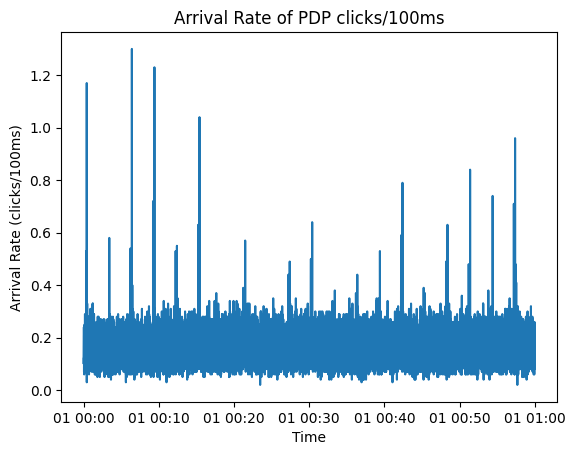

In [31]:
# read in the clicks.csv file
df = pd.read_csv('load.csv')

interval_ms = 100

# convert the epoch_ms column to a pandas datetime object
df['epoch_ms'] = pd.to_datetime(df['epoch_ms'], unit='ms')

# set the epoch_ms column as the index of the dataframe
df.set_index('epoch_ms', inplace=True)

# resample the dataframe to 100-millisecond intervals and count the number of clicks in each interval
clicks_per_interval = df['session_id'].resample(f'{interval_ms}L').count()

# calculate the arrival rate for each interval
arrival_rate = clicks_per_interval / interval_ms

# plot the arrival rates over time
import matplotlib.pyplot as plt
plt.plot(arrival_rate.index, arrival_rate)
plt.title(f'Arrival Rate of PDP clicks/{interval_ms}ms')
plt.xlabel('Time')
plt.ylabel(f'Arrival Rate (clicks/{interval_ms}ms)')
plt.show()